In [ ]:
# https://www.kaggle.com/c/nyc-taxi-trip-duration
# https://www.kaggle.com/juan1393/nyc-taxi-data-analysis

In [15]:
# https://github.com/Kaggle/kaggle-api
!pip install kaggle

You are using pip version 19.0.1, however version 19.2.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [17]:
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c nyc-taxi-trip-duration

chmod: /Users/torres.woo/.kaggle/kaggle.json: No such file or directory
Traceback (most recent call last):
  File "/Users/torres.woo/.pyenv/versions/3.6.5/bin/kaggle", line 6, in <module>
    from kaggle.cli import main
  File "/Users/torres.woo/.pyenv/versions/3.6.5/lib/python3.6/site-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/Users/torres.woo/.pyenv/versions/3.6.5/lib/python3.6/site-packages/kaggle/api/kaggle_api_extended.py", line 149, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /Users/torres.woo/.kaggle. Or use the environment method.


In [18]:
!open .
!ls

01-nyc-taxi.ipynb             lab
Untitled.ipynb                migrated
data                          nbconfig
jupyter_nbconvert_config.json nyc_taxi.zip
jupyter_notebook_config.json  train.zip
jupyter_notebook_config.py


In [27]:
pip install numpy pandas matplotlib seaborn sklearn haversine

You are using pip version 19.0.1, however version 19.2.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ROWS_SAMPLE = 8000

df = pd.read_csv("train.csv")

# Delete locations far away from the others
longitude_limit = [-74.027, -73.85]
latitude_limit = [40.67, 40.85]
df = df[(df.pickup_longitude.between(longitude_limit[0], longitude_limit[1], inclusive=False))]
df = df[(df.dropoff_longitude.between(longitude_limit[0], longitude_limit[1], inclusive=False))]
df = df[(df.pickup_latitude.between(latitude_limit[0], latitude_limit[1], inclusive=False))]
df = df[(df.dropoff_latitude.between(latitude_limit[0], latitude_limit[1], inclusive=False))]

df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"])
df["dropoff_datetime"] = pd.to_datetime(df["dropoff_datetime"])

df_trimmed = df.sample(ROWS_SAMPLE)
df_trimmed.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
1109980,id2930778,1,2016-04-05 22:29:36,2016-04-05 22:35:52,1,-73.970108,40.751408,-73.976395,40.740902,N,376
1455701,id1666955,1,2016-06-15 12:03:16,2016-06-15 12:10:01,1,-73.992012,40.735245,-74.004608,40.740734,N,405
225979,id3022978,2,2016-04-30 12:49:14,2016-04-30 13:05:48,2,-73.951782,40.773548,-73.945503,40.807671,N,994
226454,id0274355,1,2016-02-16 16:52:52,2016-02-16 17:04:47,1,-73.972702,40.793537,-73.957344,40.780708,N,715
1370433,id3305232,1,2016-01-13 14:47:11,2016-01-13 14:52:40,1,-73.960350,40.766369,-73.970360,40.758141,N,329


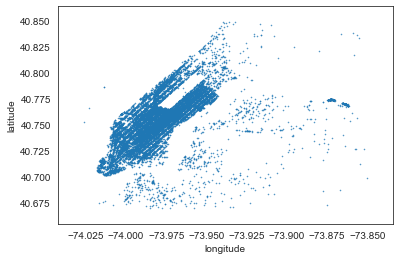

In [21]:
longitude = list(df_trimmed.pickup_longitude) + list(df_trimmed.dropoff_longitude)
latitude = list(df_trimmed.pickup_latitude) + list(df_trimmed.dropoff_latitude)

data = pd.DataFrame({'latitude': latitude, 'longitude': longitude})
sns.set_style("white")
ax = sns.regplot(x="longitude", y="latitude", data=data, scatter=True, fit_reg=False, scatter_kws={"s": 0.3})
plt.show()

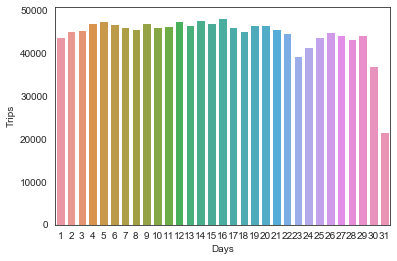

In [22]:
ax = sns.countplot(df.pickup_datetime.dt.day)
ax.set(xlabel='Days', ylabel='Trips')
plt.show()


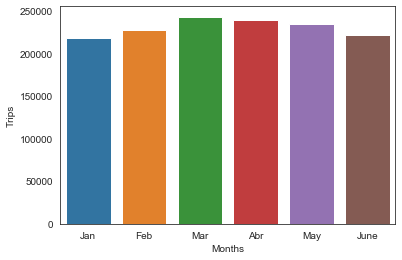

In [23]:
ax = sns.countplot(df.pickup_datetime.dt.month)
ax.set(xlabel='Months', ylabel='Trips', xticklabels=['Jan', 'Feb', 'Mar', 'Abr', 'May', 'June'])
plt.show()

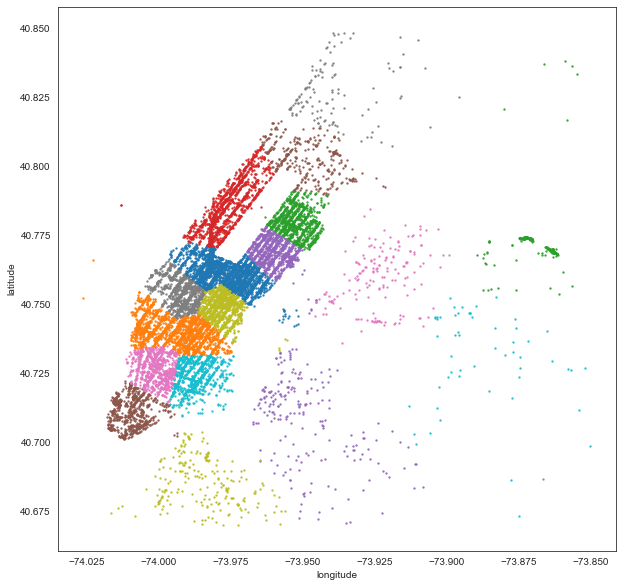

In [24]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=20, random_state=0).fit(data)
data['kmean_label'] = kmeans.labels_

plt.figure(figsize=(10, 10))
for label in data.kmean_label.unique():
    label_data = pd.DataFrame({'latitude': data.latitude[data.kmean_label == label], 'longitude': data.longitude[data.kmean_label == label]})
    sns.regplot(x="longitude", y="latitude", data=label_data, scatter=True, fit_reg=False, scatter_kws={"s": 2})

plt.show()

/Users/torres.woo/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


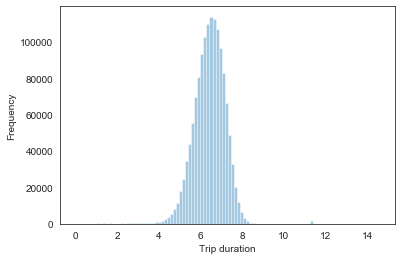

In [25]:
df.log_trip_duration = np.log(df.trip_duration)
ax = sns.distplot(df.log_trip_duration, bins=100, kde=False)
plt.xlabel('Trip duration')
plt.ylabel('Frequency')
plt.show()

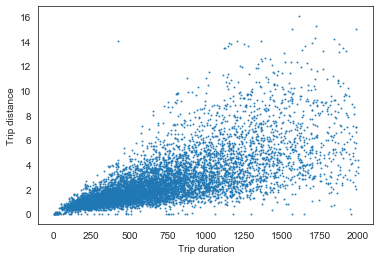

In [28]:
from haversine import haversine
df_trimmed['trip_distance'] = [haversine((row['pickup_latitude'], row['pickup_longitude']), (row['dropoff_latitude'], row['dropoff_longitude'])) for index, row in df_trimmed.iterrows()]

# Remove trip with high duration
MAX_TRIP_DURATION = 2000
df_trimmed_duration = df_trimmed[(df_trimmed.trip_duration < MAX_TRIP_DURATION)]

ax = sns.regplot(x="trip_duration", y="trip_distance", data=df_trimmed_duration, scatter=True, fit_reg=False, scatter_kws={"s": 1})
ax.set(xlabel='Trip duration', ylabel='Trip distance')
plt.show()